In [98]:
import pickle
from env import Connect4env
import sys

with open("saved_agents/mc.pkl","rb")as f:
    mc_agent=pickle.load(f)

with open("saved_agents/sarsa.pkl","rb")as f:
    sarsa_agent=pickle.load(f)

with open("saved_agents/q_learning.pkl","rb")as f:
    q_lagent=pickle.load(f)

In [99]:
from agents import SarsaLambda,QLearning
env=Connect4env()
s,l=env.reset()

agent_sarsa=SarsaLambda(env,epsilon=0.005)
agent_sarsa.q_table=sarsa_agent

agent_q=QLearning(env,epsilon=0.005)
agent_q.q_table=q_lagent

In [89]:
import sys
import numpy as np

def counter_play(env,agent1,agent2,max_episodes):
    never_seen_games=0
    full_rewards={1:[0],2:[0],0:[0]}
    for ep in range(max_episodes):        
        state,legal_moves=env.reset()
        winner=-1
        while winner==-1:
            if legal_moves ==[]:
                break

            player=env.current_player
            current_agent=agent2 if player==2 else agent1

            if tuple(state.flatten()) not in current_agent.q_table:
                never_seen_games+=1
                action=np.random.choice(legal_moves)
            else:
                action=current_agent.select_action(state,legal_moves)

            next_state, rewards, legal_moves, winner = env.step(action)
            state=next_state

  
        for players in [1,2]:
            full_rewards[players].append(full_rewards[players][-1]+rewards[players]) 



        if ep % 1000 == 0:
            print("\rEpisode {}/{}.".format(ep, max_episodes), end="")
            sys.stdout.flush()
        
    print(never_seen_games)
    return full_rewards
        

In [92]:
results=counter_play(env,agent_sarsa,agent_q,50000)

Episode 49000/50000.2023


<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wx/4x9m6jk95j3cdy5clx5kfb3w0000gn/T/ipykernel_2191/1126744759.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Sarsa ($\lambda$) vs Q-Learning")


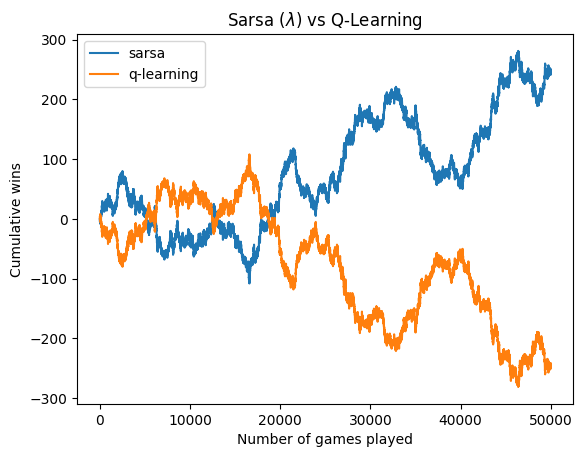

In [93]:
import matplotlib.pyplot as plt

plt.plot(results[1],label="sarsa")
plt.plot(results[2],label="q-learning")
plt.xlabel("Number of games played")
plt.ylabel("Cumulative wins")
plt.title("Sarsa ($\lambda$) vs Q-Learning")
plt.legend()

In [110]:
def choose_action_mc(state,legal_moves,monte_carlo_table):

    if tuple(state.flatten()) not in monte_carlo_table:
        action=np.random.choice(legal_moves)
    else:
        q_values=monte_carlo_table[tuple(state.flatten())]
        action = max(legal_moves, key=lambda x: q_values[x])
    
    return action

def choose_action_agent(state,agent,legal_moves):
    if tuple(state.flatten()) not in agent.q_table:
        action=np.random.choice(legal_moves)
    else:
        action=agent.select_action(state,legal_moves)
    return action

def counter_play_monte_carlo(env,monte_carlo,agent,max_episodes):
    full_rewards={1:[0],2:[0],0:[0]}
    for ep in range(max_episodes):        
        state,legal_moves=env.reset()
        winner=-1
        while winner==-1:
            if legal_moves ==[]:
                break

            player=env.current_player
            current_agent=agent if player==2 else monte_carlo

            if type(current_agent)==dict:
                action=choose_action_mc(state,legal_moves,current_agent)
            else:
                action=choose_action_agent(state,agent,legal_moves)
            
            next_state, rewards, legal_moves, winner = env.step(action)
            state=next_state

        for players in [1,2]:
            full_rewards[players].append(full_rewards[players][-1]+rewards[players]) 

        if ep % 1000 == 0:
            print("\rEpisode {}/{}.".format(ep, max_episodes), end="")
            sys.stdout.flush()
        
    return full_rewards

In [115]:
results2=counter_play_monte_carlo(env,mc_agent,agent_sarsa,50000)

Episode 49000/50000.0


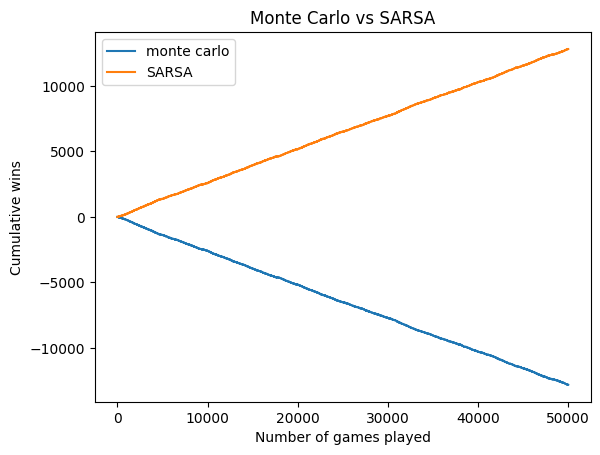

In [117]:
plt.plot(results2[1],label="monte carlo")
plt.plot(results2[2],label="SARSA")
plt.xlabel("Number of games played")
plt.ylabel("Cumulative wins")
plt.title("Monte Carlo vs SARSA")
plt.legend()

In [155]:
from agents import DQN,MCTS,ReplayMemory
import torch
model = DQN(n_observations=42,n_actions=7)
replay_memory = ReplayMemory(capacity=10_000)
model.load_state_dict(torch.load("model_mcts.pth"))

mcts = MCTS(nb_simulations=100, model=model, memory_buffer=replay_memory)

In [156]:
def choose_action_mcts(env,mcts):
    return mcts.search(env)

def counter_play_mcts(env,mcts,agent,max_episodes):
    full_rewards={1:[0],2:[0],0:[0]}
    for ep in range(max_episodes):        
        state,legal_moves=env.reset()
        winner=-1
        while winner==-1:
            if legal_moves ==[]:
                break

            player=env.current_player
            current_agent=agent if player==2 else mcts

            if type(current_agent)==MCTS:
                action=choose_action_mcts(env,current_agent)
            else:
                action=choose_action_agent(state,agent,legal_moves)
            
            next_state, rewards, legal_moves, winner = env.step(action)
            state=next_state

        for players in [1,2]:
            full_rewards[players].append(full_rewards[players][-1]+rewards[players]) 

        if ep % 100 == 0:
            print("\rEpisode {}/{}.".format(ep, max_episodes), end="")
            sys.stdout.flush()
    return full_rewards


In [159]:
results3=counter_play_mcts(env,mcts,agent_q,1000)

Episode 900/1000.

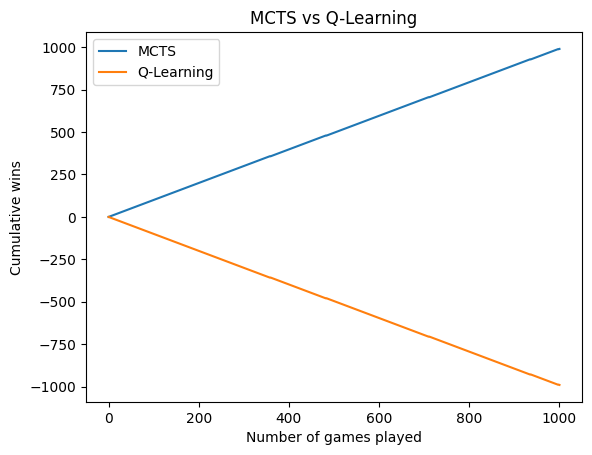

In [161]:
plt.plot(results3[1],label="MCTS")
plt.plot(results3[2],label="Q-Learning")
plt.xlabel("Number of games played")
plt.ylabel("Cumulative wins")
plt.title("MCTS vs Q-Learning")
plt.legend()